## Built Domain: Energy Transmission Metric Calculation
* % of power lines that are underground

In [74]:
import pandas as pd
import os
import sys
import boto3
import io
import geopandas as gpd
import numpy as np

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_gpkg_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '2b_reproject/built_environment/utilities/ca_energy_commission/'

pull_gpkg_from_directory(bucket_name, aws_dir)

Saved GeoPackage as 'built_cec_power_plants.gpkg' locally
Saved GeoPackage as 'built_cec_transmission_lines.gpkg' locally


In [43]:
transmission_lines = gpd.read_file('built_cec_transmission_lines.gpkg')
transmission_lines = transmission_lines.to_crs(crs=4269)
print(len(transmission_lines))

20149


<Axes: >

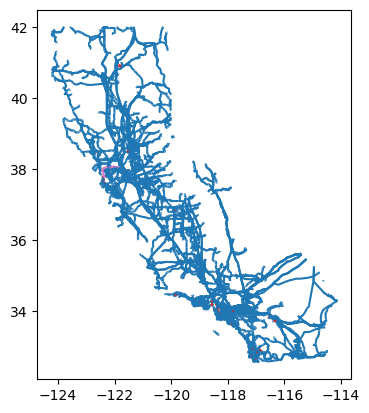

In [42]:
transmission_lines.plot(column="Type")

In [6]:
transmission_lines.columns

Index(['OBJECTID', 'Name', 'kV', 'kV_Sort', 'Owner', 'Status', 'Circuit',
       'Type', 'Legend', 'Length_Mil', 'Length_Fee', 'TLine_Name', 'Source',
       'Comments', 'Creator', 'Creator_Da', 'Last_Edito', 'Last_Edi_1',
       'GlobalID', 'SHAPE_Leng', 'USCB_STATEFP', 'USCB_COUNTYFP',
       'USCB_TRACTCE', 'USCB_GEOID', 'USCB_NAME', 'USCB_NAMELSAD',
       'USCB_MTFCC', 'USCB_FUNCSTAT', 'USCB_ALAND', 'USCB_AWATER',
       'USCB_INTPTLAT', 'USCB_INTPTLON', 'geometry'],
      dtype='object')

### Want to keep line type, it length, and its geospatial positioning

In [50]:
columns_keep = ['Type', 'Length_Mil', 'geometry']
filtered_transmission_lines = transmission_lines[columns_keep].copy()

# ensure all entries within the 'Type' column are capitalized
filtered_transmission_lines.loc[:, 'Type'] = filtered_transmission_lines['Type'].str.upper()

# drop nan line types
filtered_transmission_lines = filtered_transmission_lines.dropna(subset=['Type'])
filtered_transmission_lines

,Type,Length_Mil,geometry
0,OH,2.0,"LINESTRING (-122.23808 37.76980, -122.23805 37..."
1,OH,2.0,"LINESTRING (-122.24291 37.77242, -122.24314 37..."
2,OH,3.0,"MULTILINESTRING ((-122.24314 37.77204, -122.24..."
3,OH,2.0,"LINESTRING (-122.22366 37.76565, -122.22078 37..."
4,OH,7.0,"MULTILINESTRING ((-122.20163 37.75465, -122.20..."
...,...,...,...
20142,OH,65.0,"LINESTRING (-114.40855 34.12120, -114.40843 34..."
20143,OH,65.0,"MULTILINESTRING ((-114.51944 33.75816, -114.51..."
20144,OH,10.0,"LINESTRING (-122.34246 40.55510, -122.34162 40..."
20145,OH,1.0,"LINESTRING (-121.74353 37.98303, -121.74223 37..."


In [51]:
unique_lines = filtered_transmission_lines['Type'].unique()
unique_lines

array(['OH', 'UG', 'UW'], dtype=object)

### Separate the data into two dataframes
* overhead lines
* underground lines (with underwater lines included)

In [52]:
# Create the overhead_lines DataFrame with 'OH' entries
overhead_lines = filtered_transmission_lines[filtered_transmission_lines['Type'] == 'OH']

# Create the underground_lines DataFrame with 'UG' and 'UW' entries
underground_lines = filtered_transmission_lines[filtered_transmission_lines['Type'].isin(['UG', 'UW'])]

print("Overhead Lines:")
print(overhead_lines)
print("\nUnderground Lines:")
print(underground_lines)

Overhead Lines:
      Type  Length_Mil                                           geometry
0       OH         2.0  LINESTRING (-122.23808 37.76980, -122.23805 37...
1       OH         2.0  LINESTRING (-122.24291 37.77242, -122.24314 37...
2       OH         3.0  MULTILINESTRING ((-122.24314 37.77204, -122.24...
3       OH         2.0  LINESTRING (-122.22366 37.76565, -122.22078 37...
4       OH         7.0  MULTILINESTRING ((-122.20163 37.75465, -122.20...
...    ...         ...                                                ...
20142   OH        65.0  LINESTRING (-114.40855 34.12120, -114.40843 34...
20143   OH        65.0  MULTILINESTRING ((-114.51944 33.75816, -114.51...
20144   OH        10.0  LINESTRING (-122.34246 40.55510, -122.34162 40...
20145   OH         1.0  LINESTRING (-121.74353 37.98303, -121.74223 37...
20146   OH         9.0  LINESTRING (-122.28076 40.43669, -122.28140 40...

[19445 rows x 3 columns]

Underground Lines:
      Type  Length_Mil                            

In [8]:
# read in CA census tiger file
tract_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"

ca_tract_boundaries = gpd.read_file(tract_shp_dir)
# need to rename columns so we don't have any duplicates in the final geodatabase
column_names = ca_tract_boundaries.columns
# new_column_names = ["USCB_"+column for column in column_names if column != "geometry"]
ca_tract_boundaries = ca_tract_boundaries.rename(columns={'GEOID':"TRACT"})
ca_tract_boundaries = ca_tract_boundaries.to_crs(crs=4269) 
ca_tract_boundaries.head()

,STATEFP,COUNTYFP,TRACTCE,TRACT,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,085,504321,06085504321,5043.21,Census Tract 5043.21,G5020,S,1450237,0,+37.3931319,-121.8651427,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06,085,504410,06085504410,5044.10,Census Tract 5044.10,G5020,S,1102136,0,+37.4093719,-121.8788884,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06,085,507003,06085507003,5070.03,Census Tract 5070.03,G5020,S,9529865,0,+37.2199936,-121.9979512,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06,085,507004,06085507004,5070.04,Census Tract 5070.04,G5020,S,2424447,0,+37.2260144,-121.9763816,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06,085,502204,06085502204,5022.04,Census Tract 5022.04,G5020,S,331145,0,+37.3013832,-121.9258424,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06,059,001303,06059001303,13.03,Census Tract 13.03,G5020,S,1179647,0,+33.9209014,-117.9511671,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06,059,001304,06059001304,13.04,Census Tract 13.04,G5020,S,1252716,0,+33.9244375,-117.9455411,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
9126,06,059,001401,06059001401,14.01,Census Tract 14.01,G5020,S,1592982,15869,+33.9408240,-117.9410039,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."
9127,06,013,367200,06013367200,3672,Census Tract 3672,G5020,S,1322255,0,+37.9660275,-122.3355517,"POLYGON ((-122.34551 37.96355, -122.34550 37.9..."


### Spatial join the tract boundaries with each of the line types, starting with overhead
* sum the Length_Mil per line within a census tract
* included below this cell is code to check line lengths per tract before and after summing

In [54]:
# sjoin with tracts
joined_overhead_lines = ca_tract_boundaries.sjoin(overhead_lines).reset_index()
summed_overhead_lines = joined_overhead_lines.groupby('TRACT')['Length_Mil'].agg(['sum']).reset_index()
summed_overhead_lines = pd.merge(summed_overhead_lines,ca_tract_boundaries,on="TRACT", how='right')
summed_overhead_lines = summed_overhead_lines[['TRACT', 'sum']]
summed_overhead_lines = summed_overhead_lines.rename(columns={'TRACT':'census_tract', 'sum':'total_overhead_length_mi'})
summed_overhead_lines

,census_tract,total_overhead_length_mi
0,06085504321,NaN
1,06085504410,8.0
2,06085507003,44.0
3,06085507004,28.0
4,06085502204,8.0
...,...,...
9124,06059001303,NaN
9125,06059001304,9.0
9126,06059001401,14.0
9127,06013367200,NaN


## Check rows within a specified tract before and after summing

In [67]:
tract = '06001400100'

filtered_df = joined_overhead_lines[joined_overhead_lines['TRACT'] == tract]
filtered_df = filtered_df[['TRACT', 'Length_Mil']]

print(f'overhead transmission line rows for tract: {tract}')
print(filtered_df)
print('')

filtered_df = summed_overhead_lines[summed_overhead_lines['census_tract'] == tract]
filtered_df = filtered_df[['census_tract', 'total_overhead_length_mi']]

print(f'sum of milage for overhead transmission line rows for tract: {tract}')
print(filtered_df)

overhead transmission line rows for tract: 06001400100
             TRACT  Length_Mil
8958   06001400100         3.0
29478  06001400100         0.0
29479  06001400100         3.0

sum of milage for overhead transmission line rows for tract: 06001400100
     census_tract  total_overhead_length_mi
6900  06001400100                       6.0


### Now spatial join with underground lines (much few rows than overhead lines)

In [55]:
# sjoin with tracts
joined_underground_lines = ca_tract_boundaries.sjoin(underground_lines).reset_index()
summed_underground_lines = joined_underground_lines.groupby('TRACT')['Length_Mil'].agg(['sum']).reset_index()
summed_underground_lines = pd.merge(summed_underground_lines,ca_tract_boundaries,on="TRACT", how='right')
summed_underground_lines = summed_underground_lines[['TRACT', 'sum']]
summed_underground_lines = summed_underground_lines.rename(columns={'TRACT':'census_tract', 'sum':'total_underground_length_mi'})
summed_underground_lines

,census_tract,total_underground_length_mi
0,06085504321,NaN
1,06085504410,NaN
2,06085507003,NaN
3,06085507004,NaN
4,06085502204,NaN
...,...,...
9124,06059001303,NaN
9125,06059001304,NaN
9126,06059001401,NaN
9127,06013367200,NaN


### Merge the above and below ground spatially joined datasets together so we have total milage of lines respectively per census tract

In [76]:
all_transmission_lines = pd.merge(summed_overhead_lines,summed_underground_lines, on='census_tract')
all_transmission_lines

,census_tract,total_overhead_length_mi,total_underground_length_mi
0,06085504321,NaN,NaN
1,06085504410,8.0,NaN
2,06085507003,44.0,NaN
3,06085507004,28.0,NaN
4,06085502204,8.0,NaN
...,...,...,...
9124,06059001303,NaN,NaN
9125,06059001304,9.0,NaN
9126,06059001401,14.0,NaN
9127,06013367200,NaN,NaN


### As there are about 506 rows (out of 9129 before sjoin) that have underground values, most were nan, which wouldnt allow for a calculation to be made
* nan values were replaced with 0
* a new column was made that is the sum of above and below ground milage per tract
* another new column was made that calculated the percent of a tract has belowground transmission lines

In [82]:
# Fill NaN values with 0 across the entire DataFrame
all_transmission_lines = all_transmission_lines.fillna(0)

# Calculate the total length of transmission lines
all_transmission_lines['total_length_mi'] = all_transmission_lines['total_overhead_length_mi'] + all_transmission_lines['total_underground_length_mi']

# Calculate the percentage of underground transmission lines
# Handle division by zero by setting to 0 if total_length_mi is 0
all_transmission_lines['percent_underground_transmission_lines'] = 0
mask = all_transmission_lines['total_length_mi'] != 0
all_transmission_lines.loc[mask, 'percent_underground_transmission_lines'] = (
    all_transmission_lines['total_underground_length_mi'] / all_transmission_lines['total_length_mi']
) * 100

# Replace any remaining NaN values in 'percent_underground_transmission_lines' with 0
all_transmission_lines['percent_underground_transmission_lines'] = all_transmission_lines['percent_underground_transmission_lines'].replace({np.nan: 0})

# Print the DataFrame to verify the changes
all_transmission_lines

,census_tract,total_overhead_length_mi,total_underground_length_mi,total_length_mi,percent_underground_transmission_lines
0,06085504321,0.0,0.0,0.0,0.0
1,06085504410,8.0,0.0,8.0,0.0
2,06085507003,44.0,0.0,44.0,0.0
3,06085507004,28.0,0.0,28.0,0.0
4,06085502204,8.0,0.0,8.0,0.0
...,...,...,...,...,...
9124,06059001303,0.0,0.0,0.0,0.0
9125,06059001304,9.0,0.0,9.0,0.0
9126,06059001401,14.0,0.0,14.0,0.0
9127,06013367200,0.0,0.0,0.0,0.0


### Visualizing non 0 values

In [99]:
percent_above_zero = all_transmission_lines[all_transmission_lines['percent_underground_transmission_lines'] > 0]
print('length of non nan percentages:', len(percent_above_zero))
percent_above_zero.head(5)

length of non nan percentages: 262


,census_tract,total_overhead_length_mi,total_underground_length_mi,total_length_mi,percent_underground_transmission_lines
102,06059087302,0.0,4.0,4.0,100.000000
104,06059062657,0.0,1.0,1.0,100.000000
112,06059087301,6.0,6.0,12.0,50.000000
158,06059062614,0.0,2.0,2.0,100.000000
168,06075022803,6.0,21.0,27.0,77.777778


In [100]:
# save final df to csv for upload
all_transmission_lines.to_csv('built_energy_transmission_lines_metric.csv', index=False)

### Function Call

In [101]:
@append_metadata
def transmission_line_upload(input_csv, export=False, varname=''):
    '''
    Uploads prepared transmission lines metric csv to S3 bucket. The metrics is:
    % of power lines that are underground

    Data for this energy transmission metric was sourced from California Energy Commission at:
    https://cecgis-caenergy.opendata.arcgis.com/datasets/CAEnergy::california-electric-transmission-lines-1/about

    Methods
    -------
    Relevant columns to Cal-CRAI's metric were isolated.
    Overhead transmission lines were separated from underground and underwater lines.
    The separated types of lines were spatially joined with California 2021 census tract shape files.
    Resulting files were merged together, with toal overhead and below ground lines summed together per census tract.
    Percentage underground lines were calculated per tract by dividing summed underground/underwater lines with total line counts.
    
    Parameters
    ----------
    input_csv: string
        csv transmission lines data 
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI transmission line metric to AWS
        True = will upload resulting df containing CAL CRAI transmission line metric to AWS

    Script
    ------
    built_transmission_lines.ipynb

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    '''
    print('Data transformation: data cleaned by isolating relevant columns.')
    print('Data transformation: data was spatially joined to California census boudaries after separating overhead and below ground lines.')
    print('Data transformation: new columns calculated percentage underground/underwater lines per census tract.')

    if export == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [input_csv]
        upload_csv_aws(export_filename, bucket_name, directory)

    if os.path.exists(input_csv):
        os.remove(input_csv)

In [96]:
built_energy_csv='built_energy_transmission_lines_metric.csv'
var = 'built_cec_transmission_lines'

transmission_line_upload(built_energy_csv, export=True, varname='test')

In [102]:
all_transmission_lines

,census_tract,total_overhead_length_mi,total_underground_length_mi,total_length_mi,percent_underground_transmission_lines
0,06085504321,0.0,0.0,0.0,0.0
1,06085504410,8.0,0.0,8.0,0.0
2,06085507003,44.0,0.0,44.0,0.0
3,06085507004,28.0,0.0,28.0,0.0
4,06085502204,8.0,0.0,8.0,0.0
...,...,...,...,...,...
9124,06059001303,0.0,0.0,0.0,0.0
9125,06059001304,9.0,0.0,9.0,0.0
9126,06059001401,14.0,0.0,14.0,0.0
9127,06013367200,0.0,0.0,0.0,0.0
